In [9]:
import sys
import math

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist
import hist.plot

sys.path.append("../../..")
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from hists.parameters import beamEnergies
from hists.store import HistogramId

In [10]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v37'
clueParams = "single-file"
#clueParams = "cmssw"
histStore = HistogramStore(hist_folder, HistogramId)
datatypeToLegendMap = {"data":"Data", "sim_proton_v46_patchMIP":"Simulation"}
PCAMethodToLegendMap = {"filterLayerSpan":"No LC selection", "filterLayerSpan_cleaned":"Cleaned"}

In [11]:
def getHist(beamEnergy, datatype, angleType:str, PCA_method:str="filterLayerSpan"):
    if angleType == "angle":
        histName = "Clus3DAnglePCAToImpact"
        plotAxis = "clus3D_angle_pca_impact"
    else:
        histName = "Clus3DAnglePCAToImpact_XY"
        if angleType == "angle_x":
            plotAxis = "clus3D_angle_pca_impact_x"
        elif angleType == "angle_y":
            plotAxis = "clus3D_angle_pca_impact_y"
        else:
            raise ValueError()
    
    return (histStore.get(HistogramId(histName, clueParams, datatype))
        .getHistogram(HistogramKind.COUNT)[{
            "beamEnergy":hist.loc(beamEnergy),
            "mainOrAllTracksters":hist.loc("mainTrackster"),
            "PCA_method":hist.loc(PCA_method),
            # project on clus3D_size
        }]
    .project(plotAxis)
    )

In [12]:
getHist(20, "data", "angle_x")#.axes[0].centers

Hist(Regular(200, -0.2, 0.2, name='clus3D_angle_pca_impact_x', label='Angle from PCA axis to DWC axis, projected in (Oxz) plane'), storage=Double()) # Sum: 2007.0

In [13]:
def mpv(h:hist.Hist):
    return h.axes[0].centers[np.argmax(h.counts())]

In [27]:
def countHistogramToWeightHistogram(h:hist.Hist):
    """ Transform a count boost.histogram (ie Double storage type) to a Weight storage histogram, with weights=1 """
    w_h = hist.Hist(*h.axes, storage=hist.storage.Weight())
    w_h.view(flow=True).value, w_h.view(flow=True).variance = h.view(flow=True), h.view(flow=True)
    return w_h

def addLumiLegend(main_ax, datatypes, beamEnergies):
    if "data" in datatypes:
        hep.cms.text("Preliminary", ax=main_ax)
    else:
        hep.cms.text("Simulation Preliminary", ax=main_ax)
    if isinstance(beamEnergies, list):
        hep.cms.lumitext(f"$e^+$ test beam", ax=main_ax)
    else:
        hep.cms.lumitext(f"$e^+$ {str(beamEnergies)} GeV", ax=main_ax)
    main_ax.legend()

def plot(beamEnergies, datatypes, angleType:str, PCAMethod:str="filterLayerSpan", log=False):
    ylabel = "Event count"
    if isinstance(PCAMethod, list):
        hists = [getHist(beamEnergies, datatypes, angleType=angleType, PCA_method=PCA_method_i) for PCA_method_i in PCAMethod]
        labels = [PCAMethodToLegendMap[i] for i in PCAMethod]
    elif isinstance(datatypes, list):
        hists = [getHist(beamEnergies, datatype, angleType=angleType, PCA_method=PCAMethod) for datatype in datatypes]
        for i in range(len(datatypes)):
            if i == 0:
                count_data = hists[0].sum(flow=True)
            else:
                hists[i] = countHistogramToWeightHistogram(hists[i]) * (count_data / hists[i].sum(flow=True))
        labels = [datatypeToLegendMap[datatype] for datatype in datatypes]
    elif isinstance(beamEnergies, list):
        hists = [getHist(beamEnergy, datatypes, angleType=angleType, PCA_method=PCAMethod) for beamEnergy in beamEnergies]
        for i in range(len(beamEnergies)):
            if i == 0:
                count_first = hists[0].sum(flow=True)
            else:
                hists[i] = countHistogramToWeightHistogram(hists[i]) * (count_first / hists[i].sum(flow=True))
        labels = [f"{beamEnergy} GeV" for beamEnergy in beamEnergies]
        ylabel = "Event count (normalized)"
    else:
        hists = [getHist(beamEnergies, datatypes, angleType=angleType, PCA_method=PCAMethod)]
        labels = [""]

    for i, (h, label) in enumerate(zip(hists, labels)):
        mpv_cur = mpv(h)
        labels[i] = label + f" - MPV={mpv_cur*100:.2g} mrad ({math.degrees(mpv_cur):.2g}°)"

    fig, ax = plt.subplots()

    hep.histplot(hists, yerr=False, label=labels)

    if log:
        ax.set_yscale("log")
    
    if angleType == "angle":
        if log:
            ax.set_xlim(0, 0.25)
        else:
            ax.set_xlim(0, 0.1)
        ax.set_xlabel("Angle between PCA axis and DWC track (radians)")
    else:
        if log:
            ax.set_xlim(-0.2, 0.2)
        else:
            ax.set_xlim(-0.1, 0.1)
        if angleType == "angle_x":
            axis = "x"
        elif angleType == "angle_y":
            axis = "y"
        else:
            raise ValueError()
        ax.set_xlabel(f"Angle between the projections on (O{axis}z) plane\nof the PCA axis and DWC track (radians)")
    
    ax.set_ylabel(ylabel)

    addLumiLegend(ax, datatypes, beamEnergies)

    

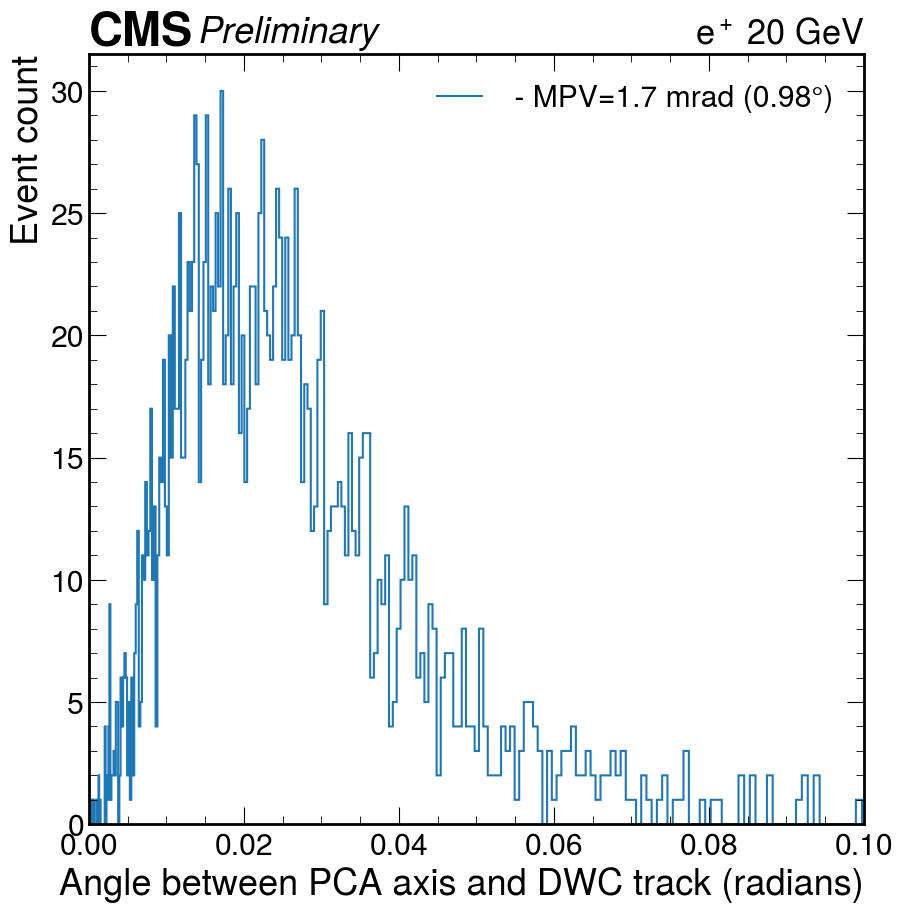

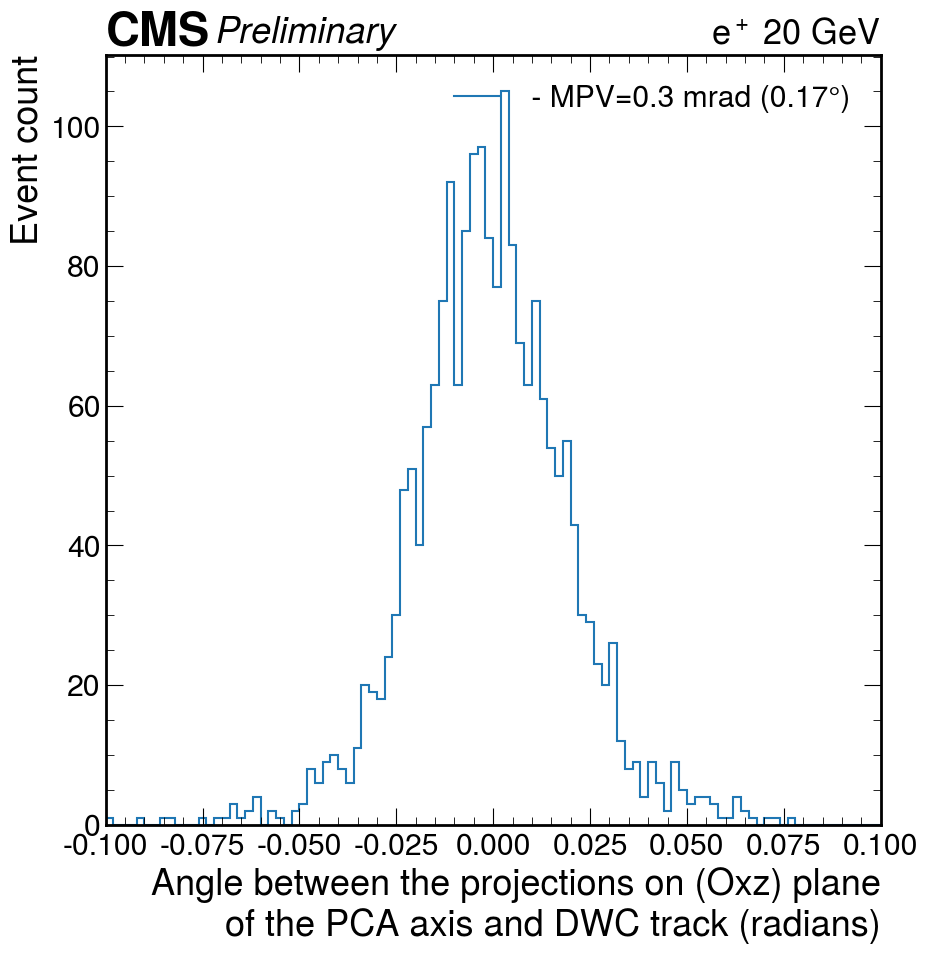

In [28]:
plot(20, "data", angleType="angle")
plot(20, "data", angleType="angle_x")

## Compare data/sim

In [18]:
plot(20, ["data", "sim_proton_v46_patchMIP"], angleType="angle")
plot(100, ["data", "sim_proton_v46_patchMIP"], angleType="angle")
plot(250, ["data", "sim_proton_v46_patchMIP"], angleType="angle")

FileNotFoundError: [Errno 2] No such file or directory: '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v37/single-file/sim_proton_v46_patchMIP/Clus3DAnglePCAToImpact.pickle'

## Compare cleaned/not cleaned

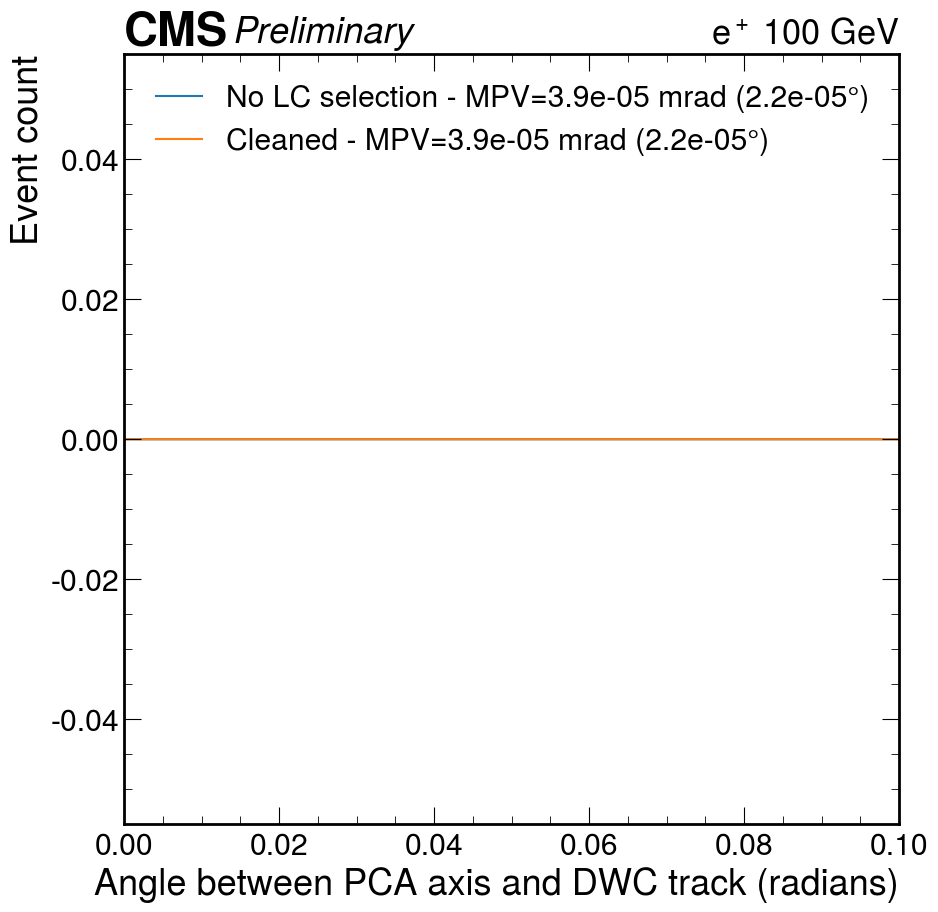

In [31]:
plot(100, "data", angleType="angle", PCAMethod=["filterLayerSpan", "filterLayerSpan_cleaned"])

## Compare beam energies

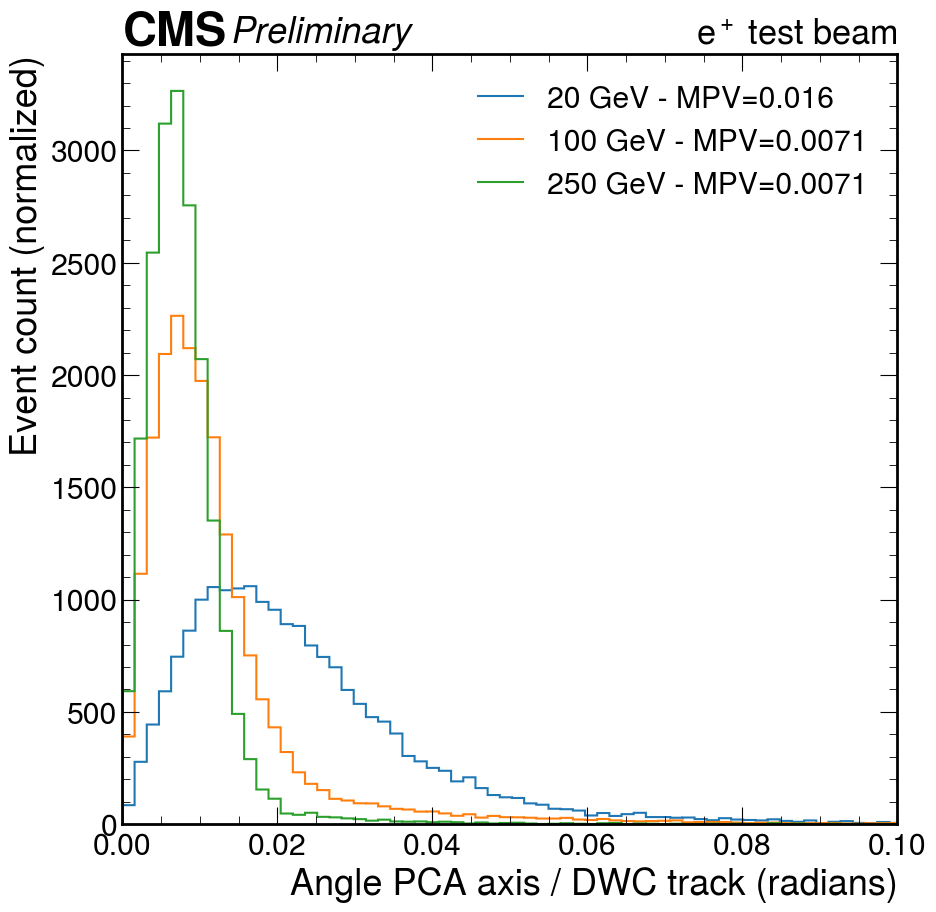

In [ ]:
plot([20, 100, 250], "data", angleType="angle")